## This notebook calibrates the Cpx-Liq machine learning barometr used by Thermobar. 
- We follow Petrelli, where a different random state is used for pressure and temperature
- Note, this will likely need rerunning a lot, because it seems if sklearn changes version too much, the pickles wont load. 
- With each change in Sklearn, the answer will likely change. The change from v023.2 resulted in a change of up to ~0.8 kbar per Cpx. This is sadly unavoidable as far as we know, although if you have a suggestion please let us know!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt
pd.set_option('display.max_columns', None)

In [2]:
out_train=pt.import_excel('Jorgenson_Input_filtered.xlsx',
                          sheet_name='Jorgenson_Input_filtered_ThBar')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Liq_train=out_train['Liqs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
Liq_train_noID_noT=Liq_train#pt.normalize_liquid_jorgenson(liq_comps=Liq_train)
Liq_train_noID_noT.drop(['Sample_ID_Liq',  'Fe3Fet_Liq', 'NiO_Liq',
                                   'CoO_Liq', 'CO2_Liq', 'H2O_Liq'], axis=1, inplace=True)
Cpx_Liq_Combo_train=pd.concat([Liq_train_noID_noT, Cpx_train_noID_noT], axis=1)
x_train=Cpx_Liq_Combo_train.values
y_train_T=out_train_input['T_K']
y_train_P=out_train_input['P_kbar']

In [3]:
Cpx_Liq_Combo_train

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx
0,52.15,1.12,10.24,19.23,0.55,4.97,9.96,1.51,0.26,0.00,0.00,52.33,0.23,1.40,12.64,0.52,15.49,16.41,0.17,0.00,0.00
1,50.59,1.10,9.59,21.10,0.50,5.10,10.16,1.64,0.22,0.00,0.00,52.05,0.24,1.66,13.79,0.51,14.65,16.38,0.21,0.00,0.00
2,72.57,0.32,14.98,2.83,0.05,0.34,2.31,2.93,3.53,0.00,0.14,48.94,0.50,3.77,21.68,0.24,10.40,12.17,0.53,0.00,0.00
3,44.86,1.25,14.12,8.98,0.18,11.82,11.45,3.37,3.03,0.18,0.77,51.16,0.37,7.15,3.42,0.05,16.94,19.03,0.74,0.00,1.32
4,47.72,0.57,18.55,8.08,0.21,10.42,11.81,2.39,0.08,0.06,0.13,50.20,0.35,9.80,4.70,0.14,18.80,16.00,0.45,0.00,0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,41.74,0.84,18.07,7.95,0.20,2.42,18.53,4.41,3.88,0.00,1.97,37.83,3.56,15.13,9.58,0.00,7.79,23.46,0.39,0.24,0.00
2075,50.19,4.62,11.48,16.16,0.00,5.08,9.79,2.44,0.23,0.00,0.00,52.10,0.81,1.47,13.90,0.00,17.80,13.40,0.12,0.00,0.00
2076,47.49,4.04,8.76,26.69,0.00,2.19,9.87,0.84,0.00,0.12,0.00,48.70,0.80,0.85,33.60,0.00,11.00,5.33,0.00,0.00,0.41
2077,51.44,2.60,17.70,11.14,0.00,4.16,9.36,3.18,0.40,0.00,0.00,48.65,1.92,5.62,8.74,0.00,13.61,21.16,0.31,0.02,0.00


In [4]:
# Scaling
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)

# Corin says max features=#*2.3
maxF=int(np.round(21*(2/3), 0))

# Define the regressor, in our case the Extra Tree Regressor
crit="absolute_error"
regr_T = ExtraTreesRegressor(n_estimators=201, criterion=crit,
                             max_features=maxF, random_state=280) # random_state fixed for reproducibility

# Define the regressor, in our case the Extra Tree Regressor
regr_P = ExtraTreesRegressor(n_estimators=201, criterion=crit, 
                             max_features=maxF, random_state=80) # random_state fixed for reproducibility

# Train the model
regr_T.fit(x_train_scaled, y_train_T.ravel())
regr_P.fit(x_train_scaled, y_train_P.ravel())

ExtraTreesRegressor(max_features=14, n_estimators=201, random_state=80)

In [6]:
from pickle import dump
dump(scaler, open('scaler_Jorg21_Cpx_Liq_April24.pkl', 'wb'))


import joblib
joblib.dump(regr_P,  'ETR_Press_Jorg21_Cpx_Liq_April24.pkl',compress=3)

joblib.dump(regr_T,  'ETR_Temp_Jorg21_Cpx_Liq_April24.pkl',compress=3)

['ETR_Temp_Jorg21_Cpx_Liq_April24.pkl']

In [11]:
x_test_scaled=scaler.transform(x_test)

NameError: name 'x_test' is not defined

## Predicting the test data for temp

'RMSE= 53.87672'

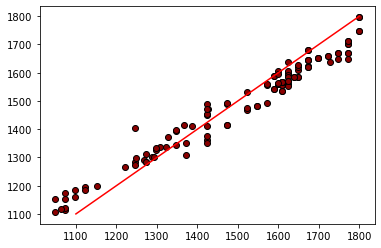

In [6]:
predicted_T=regr_T.predict(x_test_scaled)
plt.plot( y_test_T, predicted_T, 'ok', mfc='darkred')
plt.plot([1100, 1800], [1100, 1800], '-r')
Stats_T=pt.calculate_R2_np(y_test_T.values, predicted_T)
Stats_T['R2']
Stats_T['RMSE']

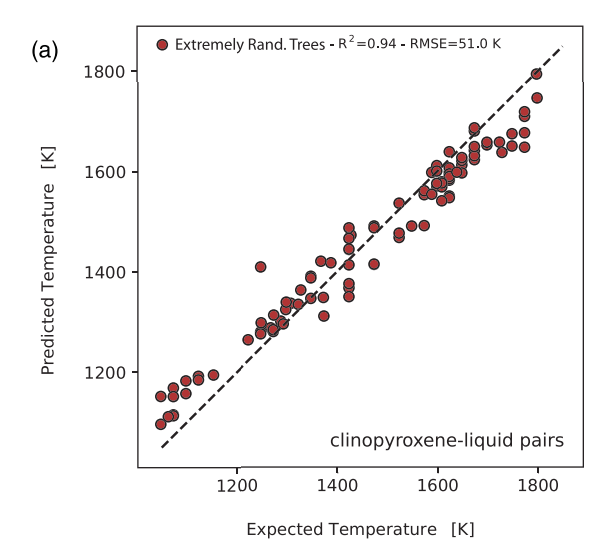

## Predicting the test data for Press

'RMSE= 2.90829'

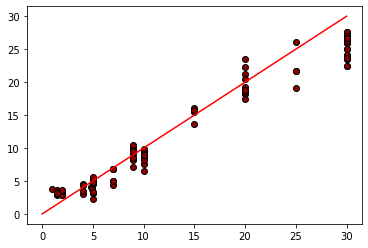

In [7]:
predicted_P=regr_P.predict(x_test_scaled)
plt.plot( y_test_P, predicted_P, 'ok', mfc='darkred')
plt.plot([0, 30], [0, 30], '-r')
Stats_P=pt.calculate_R2_np(y_test_P.values, predicted_P)
Stats_P['R2']
Stats_P['RMSE']

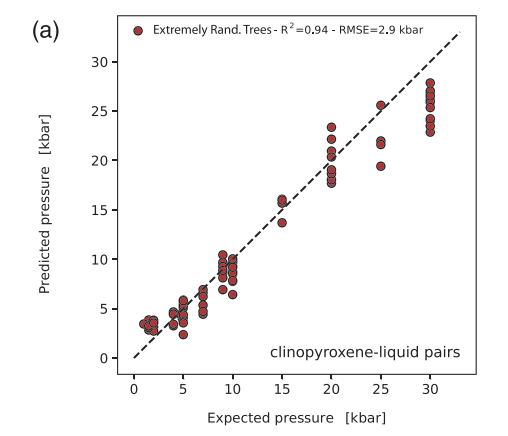

## New way, using onnx

In [17]:
#!pip install skl2onnx
from skl2onnx import __max_supported_opset__
print("Last supported opset:", __max_supported_opset__)
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 22]))]
onx = convert_sklearn(regr_P, initial_types=initial_type)
with open("Cpx_only_regr_P_Feb1_Pet20.onnx", "wb") as f:
    f.write(onx.SerializeToString())

Last supported opset: 15


In [21]:
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("Cpx_only_regr_P_Feb1_Pet20.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: x_test_scaled.astype(numpy.float32)})[0]

In [22]:
pred_onx

array([[ 2.8607016],
       [ 3.4219244],
       [ 3.2365844],
       [ 9.041351 ],
       [10.029091 ],
       [ 9.838003 ],
       [ 7.127094 ],
       [ 8.420926 ],
       [ 8.151739 ],
       [10.516232 ],
       [ 9.581179 ],
       [ 8.545492 ],
       [ 5.024453 ],
       [ 6.841339 ],
       [ 4.452662 ],
       [ 6.770219 ],
       [ 4.447101 ],
       [ 3.0329158],
       [ 4.9382124],
       [ 6.795128 ],
       [ 4.5628457],
       [ 3.4884412],
       [ 4.4417806],
       [ 3.604693 ],
       [ 3.4003077],
       [ 3.7886014],
       [ 2.8692212],
       [ 2.8757646],
       [ 3.076173 ],
       [ 3.477873 ],
       [ 3.23291  ],
       [ 3.6009905],
       [21.764967 ],
       [21.68715  ],
       [19.165604 ],
       [18.207436 ],
       [18.434006 ],
       [ 9.437095 ],
       [ 9.540871 ],
       [ 9.919147 ],
       [ 8.645819 ],
       [ 8.479236 ],
       [ 8.393109 ],
       [ 6.525839 ],
       [ 9.1254635],
       [ 7.6507854],
       [ 8.153624 ],
       [ 8.94

## Old way of dumping in Joblib

In [9]:
# from pickle import dump
# dump(scaler, open('scaler_Petrelli2020_Cpx_Liq_Jan22.pkl', 'wb'))


# import joblib
# joblib.dump(regr_P,  'ETR_Press_Petrelli2020_Cpx_Liq_Jan22.pkl',compress=3)

# joblib.dump(regr_T,  'ETR_Temp_Petrelli2020_Cpx_Liq_Jan22.pkl',compress=3)

['ETR_Temp_Petrelli2020_Cpx_Liq_Jan22.pkl']